In [7]:
# Import the necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch import Tensor


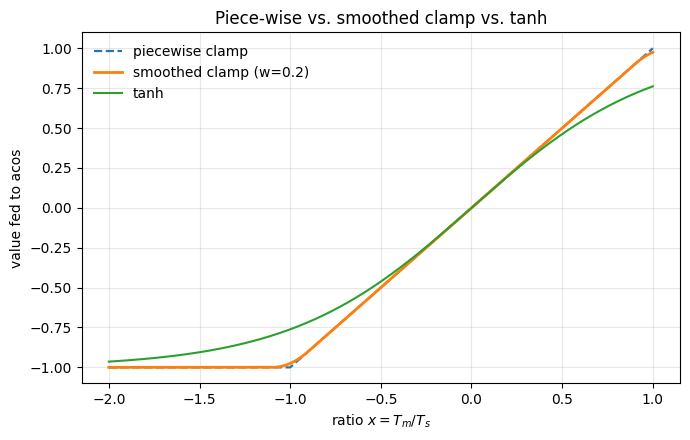

In [8]:
# --------------------------------------------------------------------------------
# domain
x = np.linspace(-2.0, 1.0, 1200)

# original piece‑wise identity / hard clamp
y_piece = np.clip(x, -1.0, 1.0)

# tanh squasher for comparison
y_tanh = np.tanh(x)

# --------------------------------------------------------------------------------
# smoothed version of the piece‑wise function
#   * identical for |x| <= 1 - w
#   * constant outside |x| >= 1 + w
#   * cubic polynomials on the two transition bands of width 2w (one on each side)
def smooth_piecewise_np(x: np.ndarray, w: float = 0.1, eps: float = 1e-6) -> np.ndarray:
    one  =  1.0 - eps
    mone = -one

    left_p  = (x + 1.0 + w) / (2.0 * w)
    right_p = (x - (1.0 - w)) / (2.0 * w)

    left_poly  = mone + w * left_p**2
    right_poly = (-w) * right_p**2 + 2.0*w*right_p + (1.0 - w)

    y = np.where(x <= -1.0 - w, mone,
         np.where(x >=  1.0 + w,  one,
           np.where(x <  -1.0 + w, left_poly,
             np.where(x >  1.0 - w,  right_poly, x))))
    return y

y_smooth = smooth_piecewise_np(x, w=0.1)

# --------------------------------------------------------------------------------
# plot
plt.figure(figsize=(7, 4.5))
plt.plot(x, y_piece,   label="piecewise clamp", linestyle="--", linewidth=1.6)
plt.plot(x, y_smooth,  label="smoothed clamp (w=0.2)", linewidth=2)
plt.plot(x, y_tanh,    label="tanh", linewidth=1.5)

plt.xlabel(r"ratio $x = T_m / T_s$")
plt.ylabel("value fed to acos")
plt.title("Piece‑wise vs. smoothed clamp vs. tanh")
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [9]:
def smooth_piecewise(x: Tensor, w: float = 0.2, eps: float = 1e-6) -> Tensor:
    one  = torch.tensor(1.0 - eps,  dtype=x.dtype, device=x.device)
    mone = -one

    left_p  = (x + 1.0 + w) / (2.0 * w)         # (-1-w , -1+w)
    right_p = (x - (1.0 - w)) / (2.0 * w)       # ( 1-w ,  1+w)

    left_poly  = mone + w * left_p.square()
    right_poly = (-w) * right_p.square() + 2.0*w*right_p + (1.0 - w)

    y = torch.where(x <= -1.0 - w, mone,
         torch.where(x >=  1.0 + w,  one,
           torch.where(x <  -1.0 + w, left_poly,
             torch.where(x >  1.0 - w,  right_poly, x))))
    return y


In [10]:
def apply_lapse_rate(topography, T_m_lowest):
    lapse_rate = 7.0 / 1000.0  # 7°C/km
    min_altitude = torch.min(topography)
    delta_alt = topography - min_altitude

    T_m = T_m_lowest - lapse_rate * delta_alt
    
    return T_m
 

def compute_integral_positive_temperature(T_m, T_s):
    """
    Computes the integral of T_abl(t) over the period where T_abl > 0 (PyTorch version).
    """
    A = 12.0  # months
    scale = 1.1 # to make the function more linear for [-0.5,0.5]
    return T_m * (A - (A / torch.pi) * torch.acos(smooth_piecewise(T_m / T_s)))+(T_s * A / torch.pi) * torch.sqrt(1 - (smooth_piecewise(T_m / T_s))**2)



def compute_negative_temperature_ratio(T_m, T_s):
    """
    Computes the ratio of the year when the temperature is negative (PyTorch version).
    Parameters:
        T_m (Tensor): 2D tensor of mean annual temperatures (on device)
        T_s (Tensor): Scalar representig the difference between summer & winter (on device)
    Returns:
        Tensor: 2D tensor of negative temperature ratios (values between 0 and 1)
    """
    scale = 1.1 # to make the function more linear for [-0.5,0.5]
    return (1.0 / torch.pi) * torch.acos(smooth_piecewise(T_m / T_s))


In [11]:
# Define SMB parameters directly
melt_f = 2 / 12  # m water / (°C·year)
smb_oggm_wat_density = 1000.0  # kg/m³
smb_oggm_ice_density = 910.0   # kg/m³

def update_smb(Z_topo, precipitation, T_m_lowest, T_s):
    """
    Compute the surface mass balance (SMB)

    Inputs:
        Z_topo         : Topography [Unit: m]
        precipitation  : Annual precip. [Unit: m y⁻¹ (water)]
        T_m_lowest     : Mean annual temp at lowest point [Unit: °C]
        T_mj_lowest    : Max month temp at lowest point [Unit: °C]

    Output:
        smb            : Surface mass balance [Unit: m ice eq. / y]
    This mass balance routine implements the OGGM surface mass balance model.
    """

    # Apply lapse rate to get temperature fields
    T_m = apply_lapse_rate(Z_topo, T_m_lowest)

    # Compute accumulation in water equivalent [m y⁻¹]
    accumulation = precipitation * compute_negative_temperature_ratio(T_m, T_s)

    # Compute ablation (melt) in water equivalent [m y⁻¹]
    ablation = melt_f * compute_integral_positive_temperature(T_m, T_s)

    # Convert to ice equivalent and compute final SMB
    smb = (accumulation - ablation) * (smb_oggm_wat_density / smb_oggm_ice_density)

    return smb


In [13]:
precip = 1.5 # e.g., m/year
T_m_lowest = 7 # °C at lowest elevation
T_s= 10  # °C at lowest elevation
nc_file = netCDF4.Dataset('../data/geology_200m.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device)

# Constant precipitation

smb = update_smb(Z_topo,precip,T_m_lowest, T_s)
torch.save(smb,'smb1.pt')


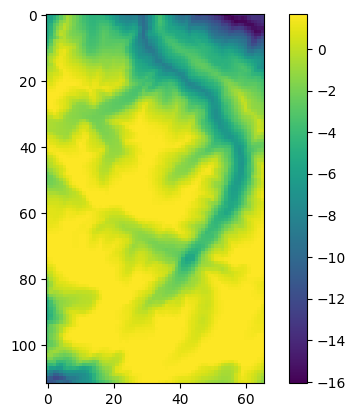

In [14]:
smb_npy = (smb).to(torch.float32).detach().cpu().numpy()

plt.imshow(smb_npy)
plt.colorbar()
plt.show()

### Prepare the spatial-temporal observations

In [15]:
# nc_file = netCDF4.Dataset('../data/geology_200m.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device)
thk_1880 = torch.tensor(nc_file.variables['thk_1880'][:], device=device)
ice_mask = torch.tensor(nc_file.variables['icemask'][:], device=device)

ttot = 100  # Time limit (yr)
t_start=1880

rho, g, fd = torch.tensor([910.0, 9.81,0.25e-16], device=device) # units [kg/m^3, m/s^-2, Pa^-3year^-1]
dx=200
dy=200
Lx=Z_topo.shape[1]*dx
Ly=Z_topo.shape[0]*dy
nc_file.close()

# torch.save(thk_1880,'Obs_2D.pt')


In [16]:
ice_mask[ice_mask<0.8]=0
# Reshape to 4D: (batch=1, channel=1, x, y)
ice_mask_4d = ice_mask.unsqueeze(0).unsqueeze(0)
kernel = torch.ones((1, 1, 3, 3), device=device)
smoothed = F.conv2d(ice_mask_4d, kernel, padding=1)
smoothed_normalized = smoothed / kernel.sum()
smoothed_mask = smoothed_normalized.squeeze()

In [17]:
class GlacierDynamicsCheckpointed(torch.nn.Module):
    def __init__(self, Z_topo, ttot, rho, g, fd, Lx, Ly, dx, dy, dtmax, device):
        super().__init__()
        self.Z_topo = Z_topo
        # self.ice_mask=ice_mask
        self.ttot = ttot
        self.rho = rho
        self.g = g
        self.fd = fd
        self.Lx = Lx
        self.Ly = Ly
        self.dx = dx
        self.dy = dy
        self.dtmax = dtmax
        self.device = device
    
        

    def forward(self, precip_tensor, T_m_lowest, T_s):
        return self.solve_glacier_dynamics(self.Z_topo, self.ttot,precip_tensor, T_m_lowest, T_s)

    def solve_glacier_dynamics(self, Z_topo, ttot,precip_tensor,T_m_lowest, T_s):
        nx = int(self.Lx / self.dx)
        ny = int(self.Ly / self.dy)

        epsilon = torch.tensor(1.e-10, device=self.device)
        H_ice = torch.zeros((ny, nx), device=self.device,requires_grad=True)

        # H_ice = H_initial.to(device=device)
        
        Z_surf = Z_topo + H_ice

        time = torch.tensor(0., device=self.device)
        # dt = torch.tensor(self.dtmax, device=self.device)
        it = torch.tensor(0., device=self.device)
        t_freq=torch.tensor(5., device=self.device)
        t_last_update=torch.tensor(0., device=self.device)
        #initial smb 
        smb = update_smb(Z_surf,precip_tensor,T_m_lowest, T_s) *smoothed_mask 

        def checkpointed_step(H_ice, Z_surf,smb, time):
            # Compute H_avg
            H_avg = 0.25 * (H_ice[:-1, :-1] + H_ice[1:, 1:] + H_ice[:-1, 1:] + H_ice[1:, :-1])

            # Compute Snorm
            Sx = (Z_surf[:, 1:] - Z_surf[:, :-1]) / self.dx
            Sy = (Z_surf[1:, :] - Z_surf[:-1, :]) / self.dy
            Sx = 0.5 * (Sx[:-1, :] + Sx[1:, :])
            Sy = 0.5 * (Sy[:, :-1] + Sy[:, 1:])
            Snorm = torch.sqrt(Sx**2 + Sy**2 + epsilon)

            D = (self.rho * self.g)**3.0 *(self.fd * H_avg**5 + 0.2e-12*H_avg**3)* Snorm**2 + epsilon

            # Compute adaptive time step.
            dt_value = min(min(self.dx, self.dy)**2 / (4.1 * torch.max(D).item()), self.dtmax)
            dt = torch.tensor(dt_value, dtype=torch.float32, device=self.device, requires_grad=True)
            # Compute fluxes
            qx = -(0.5 * (D[:-1, :] + D[1:, :])) * (Z_surf[1:-1, 1:] - Z_surf[1:-1, :-1]) / self.dx
            qy = -(0.5 * (D[:, :-1] + D[:, 1:])) * (Z_surf[1:, 1:-1] - Z_surf[:-1, 1:-1]) / self.dy

            # Compute thickness change rate
            dHdt = -(torch.diff(qx, dim=1) / self.dx + torch.diff(qy, dim=0) / self.dy)

            # Update ice thickness
            H_ice = H_ice.clone()
            H_ice[1:-1, 1:-1] = H_ice[1:-1, 1:-1] + dt * dHdt
            H_ice = H_ice.clone()

            H_ice[1:-1, 1:-1] = H_ice[1:-1, 1:-1] + dt * smb[1:-1, 1:-1]

            # Ensure ice thickness remains positive
            H_ice = torch.relu(H_ice)


            # Update surface topography
            Z_surf = Z_topo + H_ice
            return H_ice, Z_surf, time + dt

        while time < ttot:           
            
            H_ice, Z_surf, time = checkpoint(checkpointed_step, H_ice, Z_surf, smb, time)
            it += 1
            # Compute surface mass balance (SMB)
            if (time-t_last_update)>=t_freq:
                smb = update_smb(Z_surf,precip_tensor,T_m_lowest, T_s)* smoothed_mask
                
                t_last_update=time.clone()
                # Visualization call

        return H_ice 

# Wrap the solve_glacier_dynamics function in the checkpointed module
glacier_model = GlacierDynamicsCheckpointed(Z_topo, ttot, rho, g, fd, Lx, Ly, dx, dy, 1, device)


In [18]:
# Replace the direct call with a call to the checkpointed model

H_simulated = glacier_model(precip,T_m_lowest, T_s)
torch.save(H_simulated,'Obs_2D.pt')

/home/klleshi/miniconda3/envs/IGEM/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


In [19]:
def visualize(Z_surf,time,H_ice):
        plt.figure(2, figsize=(11, 4), dpi=200)
        # First subplot: Ice surface
        plt.subplot(1, 2, 1)
        plt.imshow(Z_surf.cpu().numpy(), cmap='terrain', origin='lower')
        plt.colorbar(label='Elevation (m)')
        plt.title('Ice Surface at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')
        # Second subplot: Ice thickness
        plt.subplot(1, 2, 2)
        plt.imshow(np.where(H_ice.cpu().numpy() > 0, H_ice.cpu().numpy(), np.nan), cmap='jet', origin='lower')
        plt.colorbar(label='Ice Thickness (m)')
        plt.title('Ice Thickness at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')
        # Show the plot
        plt.show()

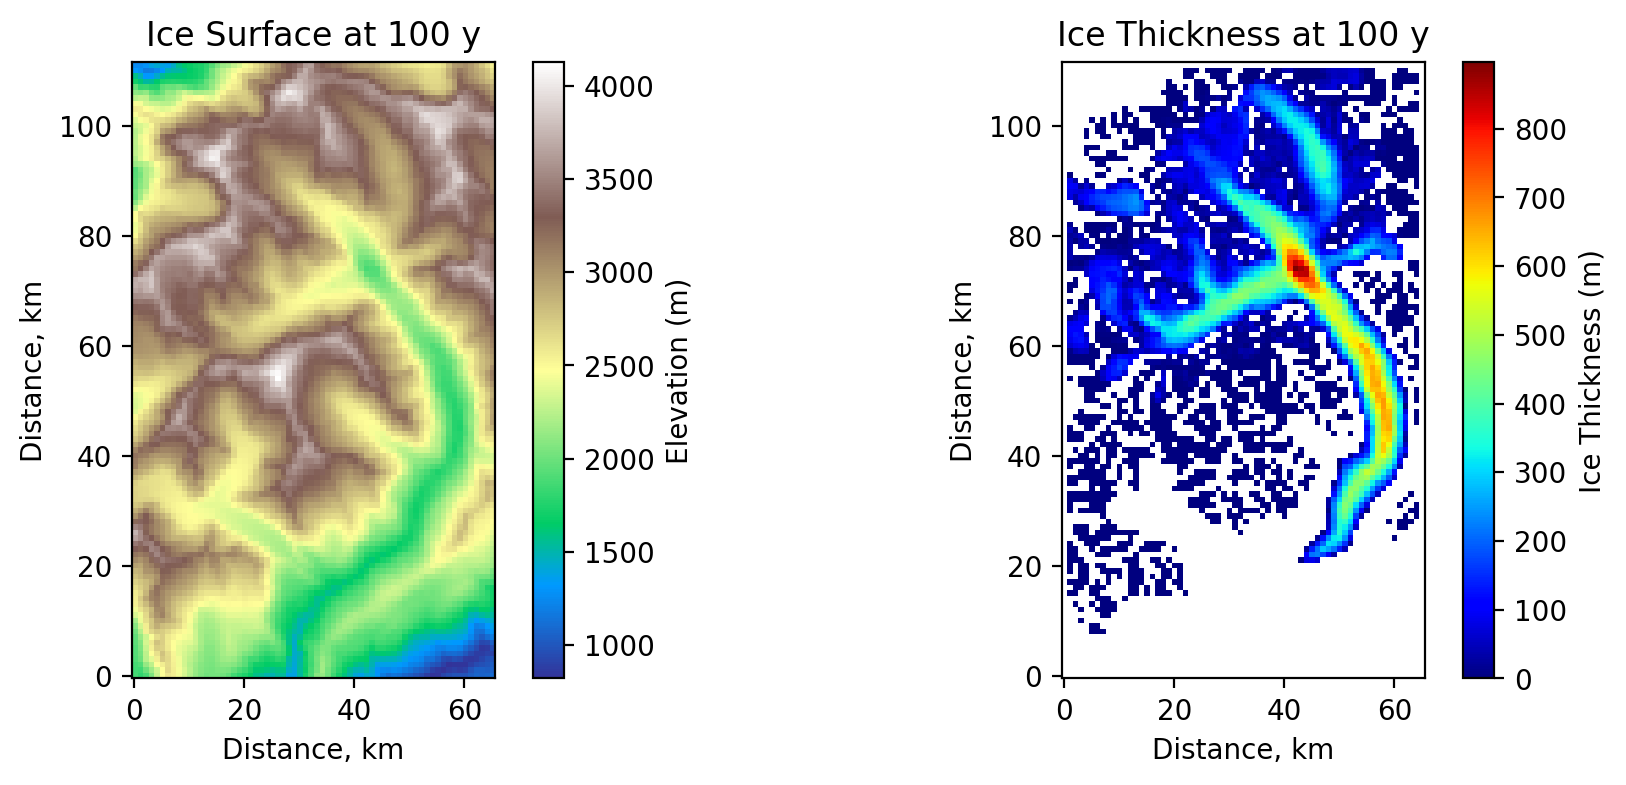

In [20]:
visualize(Z_topo,ttot,H_simulated.detach())

#### Inversion options 
**Mean Square Error (MSE)**:

* Recomended for the case where we have glacier thickness. Converges the fastest.  


**Intersection over Union (IoU)**: 

* Also known as the **Jaccard Index**, this measures the overlap between simulated and observed extents. We use this option when we do not have information about the glacier thickness.


In [21]:
# # Define a function for the forward computation to use with checkpointing
def inversion_thicknes(precip_tensor, T_m_lowest, T_s,observed_thk, reg_lambda, scale):
    # Perform forward simulation
    H_simulated = glacier_model(precip_tensor,T_m_lowest, T_s,scale)
    # Compute data fidelity term
    data_fidelity = torch.mean(torch.abs(H_simulated - observed_thk) ** 2)/torch.norm(observed_thk)

    # # Compute smoothness regularization
    # smoothness_x = torch.sum((precip_tensor[:, 1:] - precip_tensor[:, :-1]) ** 2)
    # smoothness_y = torch.sum((precip_tensor[1:, :] - precip_tensor[:-1, :]) ** 2)
    # smoothness_reg = smoothness_x + smoothness_y

    # Total loss
    loss = data_fidelity #+ reg_lambda * smoothness_reg
    return loss,H_simulated, data_fidelity

# Define a function for the forward computation to use with checkpointing
def inversion_extent(precip_tensor, T_m_lowest, T_s,observed_thk,reg_lambda):
    """
    Forward computation with IoU for data fidelity and smoothness regularization.
    Args:
        Z_ELA (torch.Tensor): The equilibrium line altitude field.
        observed_thk (torch.Tensor): The observed glacier thickness.
        reg_lambda (float): Regularization parameter for smoothness.
        threshold (float): Thickness threshold to define glacier extent.
    Returns:
        loss (torch.Tensor): Total loss including IoU and regularization.
        H_simulated (torch.Tensor): Simulated glacier thickness.
    """
    # Perform forward simulation
    H_simulated = glacier_model(precip_tensor,T_m_lowest, T_s)  # Use the checkpointed glacier model
    
    # Steeper sigmoid using a scaling factor
    scale = 100.0
    mask_simulated = torch.sigmoid(scale * (H_simulated - 1))
    mask_observed = torch.sigmoid(scale * (observed_thk - 1))

    # Compute data fidelity term
    data_fidelity = torch.mean(torch.abs(mask_simulated - mask_observed) ** 2)
    # # Compute smoothness regularization
    # smoothness_x = torch.sum((precip_tensor[:, 1:] - precip_tensor[:, :-1]) ** 2)
    # smoothness_y = torch.sum((precip_tensor[1:, :] - precip_tensor[:-1, :]) ** 2)
    # smoothness_reg = smoothness_x + smoothness_y
    
    # Total loss
    loss = data_fidelity #+ reg_lambda * smoothness_reg

    return loss, H_simulated, data_fidelity


In [22]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()

# Initial guesses for inversion problem
precip_tensor = torch.tensor(1.5, requires_grad=False, device=device)
T_m_lowest = torch.tensor(5.0, requires_grad=True, device=device)
# T_s = torch.tensor(10.0, requires_grad=True, device=device)

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('Obs_2D.pt').to(device)

initial_lr = 0.05
# final_lr = 0.05  # You can set this to any small value
reg_lambda = 0.00051
n_iterations = 50
# Optimizer setup
optimizer = torch.optim.Adam([T_m_lowest], lr=initial_lr)

# Tracking variables
total_loss_history = []
data_fidelity_history = []
Precip_history = []
learning_rate_history = []

# Early stopping parameters
early_stop_patience = 10
early_stop_threshold = 5e-3

# Internal early stopping state
best_loss = float('inf')
no_improve_count = 0

for i in range(n_iterations):
    # # --- Linearly decay the learning rate ---
    # current_lr = initial_lr - (initial_lr - final_lr) * (i / n_iterations)
    # for param_group in optimizer.param_groups:
    #     param_group['lr'] = current_lr
    # learning_rate_history.append(current_lr)

    start_time = time.time()
    optimizer.zero_grad()

    # Forward pass
    loss, H_simulated, data_fidelity = inversion_extent(
        precip_tensor, T_m_lowest, T_s, observed_thk,reg_lambda
    )

    # Backward pass
    loss.backward()

   
    optimizer.step()

    # Timing and logging
    elapsed_time = time.time() - start_time
    print(f"Iter {i+1}: loss={loss:.3f}, precip={precip_tensor.item():.3f}, T={T_m_lowest.item():.3f}")


    # Store history
    Precip_history.append(precip_tensor.item())
    data_fidelity_history.append(data_fidelity.item())


    # # Early stopping check
    # if best_loss - loss.item() > early_stop_threshold:
    #     best_loss = loss.item()
    #     no_improve_count = 0
    # else:
    #     no_improve_count += 1
    #     print(f"No significant improvement for {no_improve_count} iteration(s).")

    # if no_improve_count >= early_stop_patience:
    #     print(f"Early stopping triggered at iteration {i + 1}.")
    #     break

    # if loss.item() <= 0.001:
    #     print(f"Early stopping triggered at iteration {i + 1}.")
    #     break

/tmp/ipykernel_42820/4255402532.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  observed_thk = torch.load('Obs_2D.pt').to(device)


Iter 1: loss=0.062, precip=1.500, T=5.050
Iter 2: loss=0.061, precip=1.500, T=5.091
Iter 3: loss=0.058, precip=1.500, T=5.123
Iter 4: loss=0.056, precip=1.500, T=5.156
Iter 5: loss=0.055, precip=1.500, T=5.193
Iter 6: loss=0.053, precip=1.500, T=5.227
Iter 7: loss=0.051, precip=1.500, T=5.258


KeyboardInterrupt: 

In [23]:
T_m_lowest,precip_tensor

(tensor(5.2578, device='cuda:0', requires_grad=True),
 tensor(1.5000, device='cuda:0'))

In [24]:
# torch.save(precip_tensor,"percip.pt")

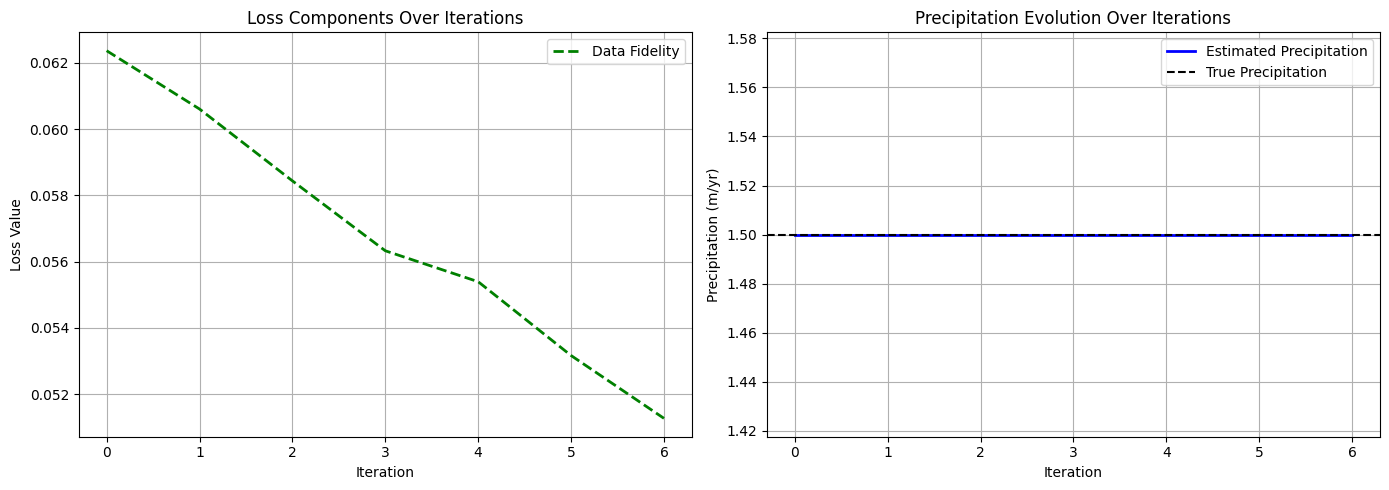

In [25]:

def plot_loss_and_precipitation(data_fidelity_history, Precip_history, name, true_precip):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Two subplots side by side

    # First subplot: Loss components
    axs[0].plot(data_fidelity_history, label='Data Fidelity', color='g', linestyle='--', linewidth=2)
    axs[0].set_title('Loss Components Over Iterations')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss Value')
    axs[0].legend()
    axs[0].grid(True)

    # Second subplot: Precipitation evolution
    axs[1].plot(Precip_history, label='Estimated Precipitation', color='b', linewidth=2)
    axs[1].axhline(y=true_precip, color='k', linestyle='--', label='True Precipitation')
    axs[1].set_title('Precipitation Evolution Over Iterations')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Precipitation (m/yr)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig(name)
    plt.show()

# Example call
plot_loss_and_precipitation(data_fidelity_history, Precip_history, 'loss_and_precip.png', true_precip=1.5)


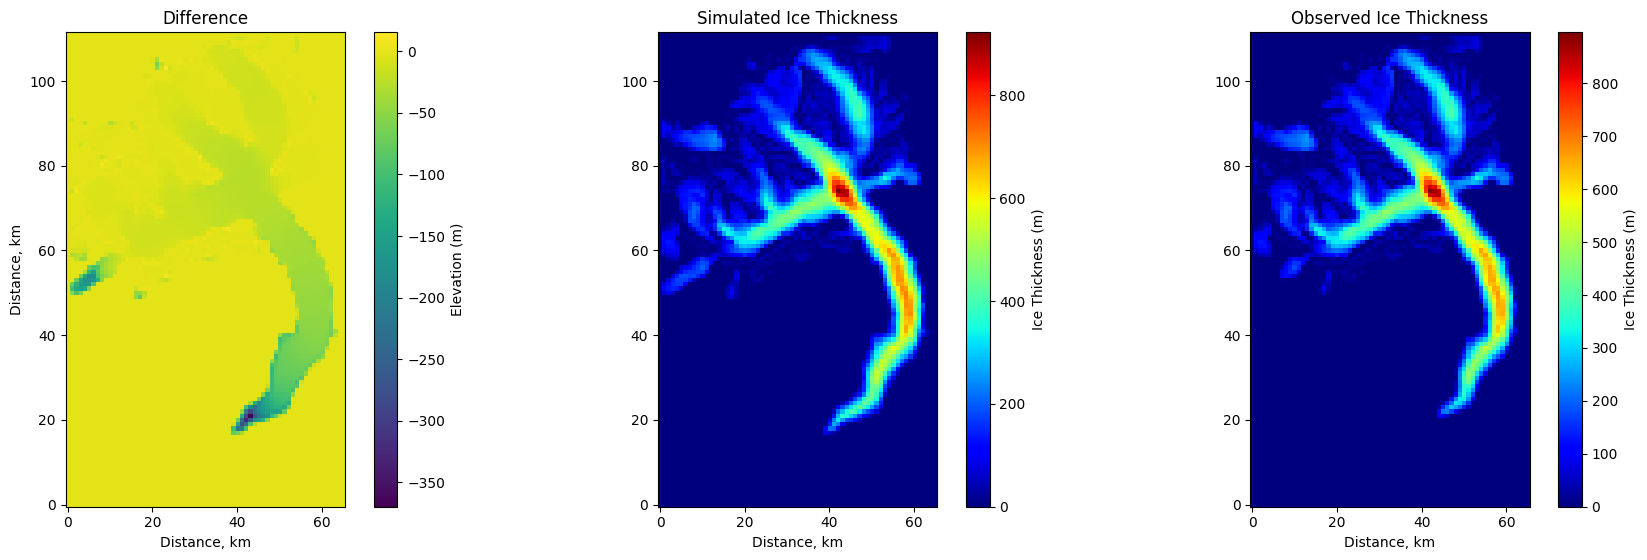

In [19]:
# Convert tensors to NumPy arrays for plotting
Z_ELA_np = precip_tensor.to(torch.float32).detach().cpu().numpy()
H_ice_np = H_simulated.to(torch.float32).detach().cpu().numpy()
observed_thk_np = observed_thk.to(torch.float32).detach().cpu().numpy()

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for better layout

# Plot the ELA field
im1 = ax[0].imshow(observed_thk_np-H_ice_np, origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Elevation (m)')
ax[0].set_title('Difference')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow( H_ice_np, cmap='jet', origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Ice Thickness (m)')
ax[1].set_title('Simulated Ice Thickness')
ax[1].set_xlabel('Distance, km')

# Third subplot: Observed ice thickness
im3 = ax[2].imshow(observed_thk_np, cmap='jet', origin='lower')
fig.colorbar(im3, ax=ax[2], orientation='vertical', label='Ice Thickness (m)')
ax[2].set_title('Observed Ice Thickness')
ax[2].set_xlabel('Distance, km')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


In [20]:
# Convert tensors to NumPy arrays for plotting
Precipitation = precip_tensor.to(torch.float32).detach().cpu().numpy()
mean_anual_T= apply_lapse_rate(Z_topo+H_simulated, T_m)

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize for better layout

# Plot the ELA field
im1 = ax[0].imshow(Precipitation, cmap='terrain', origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='[m/year]')
ax[0].set_title('Reconstructed Precipitation Field')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow(mean_anual_T.detach().cpu().numpy(), cmap='jet', origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='[degree C]')
ax[1].set_title('Mean Anual Temperature')
ax[1].set_xlabel('Distance, km')

# Add a main title
fig.suptitle('Paleo climate reconstruction', fontsize=16)
value 
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()

NameError: name 'T_m' is not defined

In [ ]:
# Convert tensors to NumPy arrays for plotting
Precipitation = precip_tensor.to(torch.float32).detach().cpu().numpy()
Z_ELA_np = Precipitation[0]
H_ice_np = H_simulated.to(torch.float32).detach().cpu().numpy()
observed_thk_np = observed_thk.to(torch.float32).detach().cpu().numpy()
mean_anual_T, mean_June_T = apply_lapse_rate(Z_topo + H_simulated, T_ma_lowest, T_mj_lowest)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 10))

# --- Top Row ---
# Reconstructed Precipitation
im0 = axs[0, 0].imshow(Z_ELA_np, cmap='terrain', origin='lower')
fig.colorbar(im0, ax=axs[0, 0], orientation='vertical', label='[m/year]')
axs[0, 0].set_title('Reconstructed Precipitation Field')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Distance, km')

# Simulated Ice Thickness
im1 = axs[0, 1].imshow(H_ice_np, cmap='jet', origin='lower')
fig.colorbar(im1, ax=axs[0, 1], orientation='vertical', label='Ice Thickness [m]')
axs[0, 1].set_title('Simulated Ice Thickness')
axs[0, 1].set_xlabel('')
# Remove y-axis for top-right panel
axs[0, 1].set_ylabel('')
axs[0, 1].set_yticklabels([])

# --- Bottom Row ---
# Mean Annual Temperature
im2 = axs[1, 0].imshow(mean_anual_T.detach().cpu().numpy(), cmap='jet', origin='lower')
fig.colorbar(im2, ax=axs[1, 0], orientation='vertical', label='[°C]')
axs[1, 0].set_title('Mean Annual Temperature')
axs[1, 0].set_xlabel('Distance, km')
axs[1, 0].set_ylabel('Distance, km')

# Thickness Difference (Observed - Simulated)
im3 = axs[1, 1].imshow(observed_thk_np - H_ice_np, cmap='coolwarm', origin='lower')
fig.colorbar(im3, ax=axs[1, 1], orientation='vertical', label='Difference [m]')
axs[1, 1].set_title('Thickness Difference (Obs - Simul)')
axs[1, 1].set_xlabel('Distance, km')
# Remove y-axis for bottom-right panel
axs[1, 1].set_ylabel('')
axs[1, 1].set_yticklabels([])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()